# Etude d'un dataset pour prédire le prix d'une maison

- On va ici essayer de prédire le prix d'une maison en fonction de : 

- id : Identifiant de la vente,

- date : Date de la vente,

- nb_chambres : Nombre de chambres,

- nb_sdb : Nombre de salles de bain, les valeurs 0.5 correspondent aux WC sans douche/baignoire,

- m2_interieur : Surface en m2 de l'espace vivable de la maison,

- m2_jardin : Surface en m2 de l'espace extérieur,

- m2_etage : Surface en m2 des pièces situées au dessus du niveau du sol,

- m2_soussol : Surface en m2 des pièces situées en dessous du niveau du sol,

- nb_etages : Nombre d'étages,

- vue_mer : Variable booléenne indiquant s'il y a une vue sur mer ou non,

- vue_note : Note entre 0 et 4 indiquant la qualité de la vue,

- etat_note : Note de 1 à 5 indiquant l'état de la maison,

- design_note : Note de 1 à 13 indiquant le niveau de design de la maison,

- annee_construction : Année de construction,

- annee_renovation : Dernière année de rénovation s'il y a eu, sinon 0,

- m2_interieur_15voisins : Surface en m2 de l'espace vivable des 15 voisins les plus proches,

- m2_jardin_15voisins : Surface en m2 de l'espace extérieur des 15 voisins les plus proches,

- zipcode : Zipcode de l'adresse de la maison

- lat : latitude,

- long : longitude

on s'entraine sur train, la soumission se fait à partir des données de test. le fichier submission donne le format de la soumission. c'est juste un exemple de prix mais pas la valeur réelle

idée : variable target : prix au m2 et pas prix

outliers : (bcp de chambres et prix enorme) peut etre les enlever

zip code ne doit pas etre traitée comme var quantitative, c'est une var qualitative
strategie : faire paquet en fonciton du zip code(clustering en fonction prix selon zipcode ?)

question à poser au prof : pour le split train test : il faut séparer les dernieres dates (et donc trier par ordre chronologique) et pas séparer en random si ?

In [35]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

# Prétraitement et clustering
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
from sklearn.cluster import AgglomerativeClustering, KMeans

# Analyse statistique
from statsmodels.api import OLS, add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Évaluation des modèles
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Pour le dendrogramme
from scipy.cluster.hierarchy import dendrogram



In [36]:
path = "C:/Users/rapha/OneDrive/Bureau/ENPC/2A/SEMESTRE 2/PRAMA/PRAMA2025/train_data.csv"
data = pd.read_csv(path)
print(data.columns)
data.head()



Index(['id', 'date', 'prix', 'nb_chambres', 'nb_sdb', 'm2_interieur',
       'm2_jardin', 'm2_etage', 'm2_soussol', 'nb_etages', 'vue_mer',
       'vue_note', 'etat_note', 'design_note', 'annee_construction',
       'annee_renovation', 'm2_interieur_15voisins', 'm2_jardin_15voisins',
       'zipcode', 'lat', 'long'],
      dtype='object')


,id,date,prix,nb_chambres,nb_sdb,m2_interieur,m2_jardin,m2_etage,m2_soussol,nb_etages,...,vue_note,etat_note,design_note,annee_construction,annee_renovation,m2_interieur_15voisins,m2_jardin_15voisins,zipcode,lat,long
0,4443800785,2014-11-21T00:00:00Z,481000,2,1.00,150.501672,360.460795,85.470085,65.031587,1.0,...,0,4,7,1924,0,123.560015,360.460795,98117,47.6855,-122.391
1,2722059013,2015-02-04T00:00:00Z,550000,2,1.00,117.985879,4046.822742,117.985879,0.000000,1.0,...,0,4,5,1908,0,173.727239,646.599777,98042,47.3651,-122.165
2,8856004730,2014-09-17T00:00:00Z,199950,2,2.75,147.714604,1943.236715,147.714604,0.000000,1.5,...,0,3,5,1920,0,121.701970,557.413601,98001,47.2786,-122.250
3,2473003210,2015-03-13T00:00:00Z,364808,3,1.75,215.533259,731.605351,150.501672,65.031587,1.0,...,0,3,8,1967,0,184.875511,903.010033,98058,47.4524,-122.146
4,6743700335,2014-06-04T00:00:00Z,470000,3,2.00,167.224080,1176.978818,167.224080,0.000000,1.0,...,0,3,7,1956,1990,183.017466,908.119658,98033,47.6935,-122.173


In [37]:
path_pred = "C:/Users/rapha/OneDrive/Bureau/ENPC/2A/SEMESTRE 2/PRAMA/PRAMA2025/test_data.csv"
data_pred = pd.read_csv(path_pred)
print(data_pred.columns)
data_pred.head()

Index(['id', 'date', 'nb_chambres', 'nb_sdb', 'm2_interieur', 'm2_jardin',
       'm2_etage', 'm2_soussol', 'nb_etages', 'vue_mer', 'vue_note',
       'etat_note', 'design_note', 'annee_construction', 'annee_renovation',
       'm2_interieur_15voisins', 'm2_jardin_15voisins', 'zipcode', 'lat',
       'long', 'year', 'month', 'cos_month', 'prix'],
      dtype='object')


,id,date,nb_chambres,nb_sdb,m2_interieur,m2_jardin,m2_etage,m2_soussol,nb_etages,vue_mer,...,annee_renovation,m2_interieur_15voisins,m2_jardin_15voisins,zipcode,lat,long,year,month,cos_month,prix
0,3600072,2015-03-30,4,2.75,206.243032,493.311037,108.695652,97.547380,1.0,0,...,0,143.069491,390.189521,98144,47.5801,-122.294,2015,3,-0.989992,NaN
1,6200017,2014-11-12,3,1.00,124.489038,1982.162765,124.489038,0.000000,1.5,0,...,0,124.489038,3502.694166,98032,47.4023,-122.273,2014,11,0.004426,NaN
2,7600136,2014-07-18,2,2.00,104.979562,106.651802,74.321813,30.657748,2.0,0,...,0,125.418060,111.575622,98122,47.6023,-122.314,2014,7,0.753902,NaN
3,11200400,2014-09-23,3,2.50,177.443330,416.945373,177.443330,0.000000,2.0,0,...,0,142.140468,343.366778,98007,47.6176,-122.140,2014,9,-0.911130,364808.0
4,11500890,2015-03-12,3,2.50,290.784095,812.894835,290.784095,0.000000,2.0,0,...,0,265.700483,836.399108,98052,47.6954,-122.103,2015,3,-0.989992,NaN


In [38]:
data['date'] = pd.to_datetime(data['date'], errors='coerce')
data['date'] = data['date'].map(lambda x: str(x).split(' ')[0])

In [39]:
data_pred['date'] = pd.to_datetime(data_pred['date'], errors='coerce')
data_pred['date'] = data_pred['date'].map(lambda x: str(x).split(' ')[0])

In [40]:
data.head()

,id,date,prix,nb_chambres,nb_sdb,m2_interieur,m2_jardin,m2_etage,m2_soussol,nb_etages,...,vue_note,etat_note,design_note,annee_construction,annee_renovation,m2_interieur_15voisins,m2_jardin_15voisins,zipcode,lat,long
0,4443800785,2014-11-21,481000,2,1.00,150.501672,360.460795,85.470085,65.031587,1.0,...,0,4,7,1924,0,123.560015,360.460795,98117,47.6855,-122.391
1,2722059013,2015-02-04,550000,2,1.00,117.985879,4046.822742,117.985879,0.000000,1.0,...,0,4,5,1908,0,173.727239,646.599777,98042,47.3651,-122.165
2,8856004730,2014-09-17,199950,2,2.75,147.714604,1943.236715,147.714604,0.000000,1.5,...,0,3,5,1920,0,121.701970,557.413601,98001,47.2786,-122.250
3,2473003210,2015-03-13,364808,3,1.75,215.533259,731.605351,150.501672,65.031587,1.0,...,0,3,8,1967,0,184.875511,903.010033,98058,47.4524,-122.146
4,6743700335,2014-06-04,470000,3,2.00,167.224080,1176.978818,167.224080,0.000000,1.0,...,0,3,7,1956,1990,183.017466,908.119658,98033,47.6935,-122.173


In [41]:
data['year'] = data['date'].map(lambda x: int(x.split('-')[0]))
data['month'] = data['date'].map(lambda x: int(x.split('-')[1]))
data['cos_month'] = data['month'].map(lambda x: np.cos(np.pi*float(x)/12))

In [42]:
data_pred['year'] = data_pred['date'].map(lambda x: int(x.split('-')[0]))
data_pred['month'] = data_pred['date'].map(lambda x: int(x.split('-')[1]))
data_pred['cos_month'] = data_pred['month'].map(lambda x: np.cos(np.pi*float(x)/12))

In [43]:
data.head()

,id,date,prix,nb_chambres,nb_sdb,m2_interieur,m2_jardin,m2_etage,m2_soussol,nb_etages,...,annee_construction,annee_renovation,m2_interieur_15voisins,m2_jardin_15voisins,zipcode,lat,long,year,month,cos_month
0,4443800785,2014-11-21,481000,2,1.00,150.501672,360.460795,85.470085,65.031587,1.0,...,1924,0,123.560015,360.460795,98117,47.6855,-122.391,2014,11,-9.659258e-01
1,2722059013,2015-02-04,550000,2,1.00,117.985879,4046.822742,117.985879,0.000000,1.0,...,1908,0,173.727239,646.599777,98042,47.3651,-122.165,2015,2,8.660254e-01
2,8856004730,2014-09-17,199950,2,2.75,147.714604,1943.236715,147.714604,0.000000,1.5,...,1920,0,121.701970,557.413601,98001,47.2786,-122.250,2014,9,-7.071068e-01
3,2473003210,2015-03-13,364808,3,1.75,215.533259,731.605351,150.501672,65.031587,1.0,...,1967,0,184.875511,903.010033,98058,47.4524,-122.146,2015,3,7.071068e-01
4,6743700335,2014-06-04,470000,3,2.00,167.224080,1176.978818,167.224080,0.000000,1.0,...,1956,1990,183.017466,908.119658,98033,47.6935,-122.173,2014,6,6.123234e-17


seule la  variable vue_mer est qualitative (0 : pas de vue mer, 1 sinon).

In [44]:
zeros = len(data[data['prix'] == 0])
missed = len(data[data['prix']=='NaN'])
print(zeros, missed)

0 0


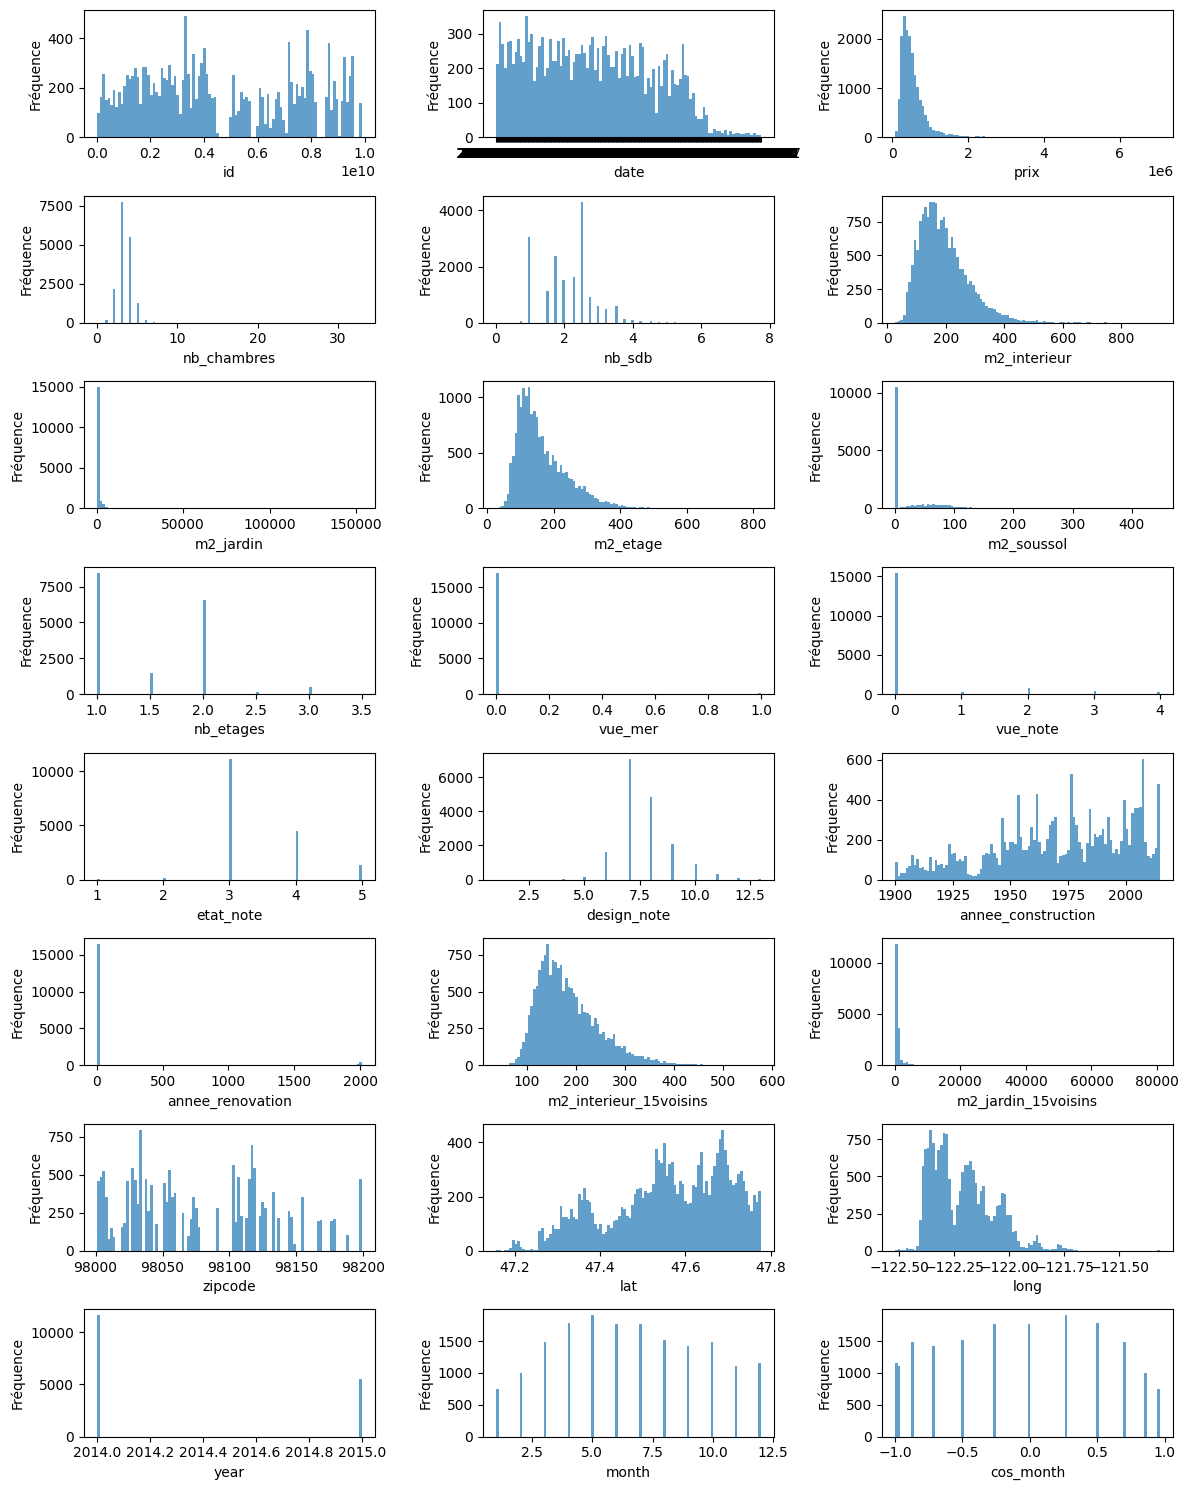

In [45]:


plt.figure(figsize=(12, 15))
columns = data.columns


for i, column in enumerate(columns):
    plt.subplot((len(columns) + 2) // 3, 3, i + 1)  # Calcule le nombre de lignes de sous-graphiques
    plt.hist(data[column], bins=100, alpha=0.7)
    plt.xlabel(column)
    plt.ylabel('Fréquence')

plt.tight_layout()  # Ajuste les espacements pour éviter le chevauchement
plt.show()


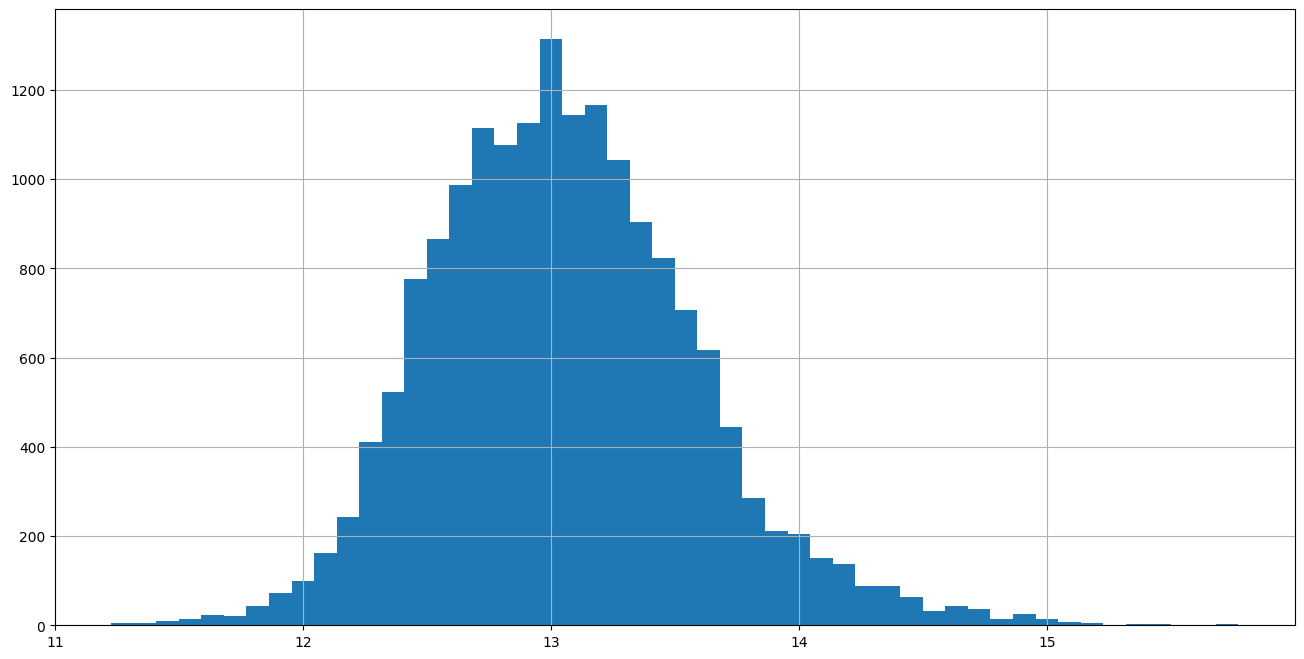

In [46]:
data['prix'].apply(lambda x: np.log(x)).hist(bins=50, figsize=(16, 8))
plt.show()

In [47]:
from pandas.plotting import scatter_matrix
data.describe()

,id,prix,nb_chambres,nb_sdb,m2_interieur,m2_jardin,m2_etage,m2_soussol,nb_etages,vue_mer,...,annee_construction,annee_renovation,m2_interieur_15voisins,m2_jardin_15voisins,zipcode,lat,long,year,month,cos_month
count,1.714700e+04,1.714700e+04,17147.000000,17147.000000,17147.000000,17147.000000,17147.000000,17147.000000,17147.000000,17147.000000,...,17147.000000,17147.000000,17147.000000,17147.000000,17147.000000,17147.000000,17147.000000,17147.000000,17147.000000,1.714700e+04
mean,4.605475e+09,5.431939e+05,3.371669,2.123010,193.732114,1411.998121,166.652667,27.079448,1.497638,0.008048,...,1971.154721,86.124453,184.852674,1187.418834,98077.654808,47.560131,-122.213735,2014.322389,6.573103,-9.978783e-02
std,2.879726e+09,3.716087e+05,0.932029,0.772906,85.587837,3879.062125,77.312579,41.221029,0.542015,0.089352,...,29.378196,405.556968,64.023277,2504.936376,53.455894,0.138478,0.140614,0.467405,3.106316,6.442129e-01
min,1.000102e+06,7.500000e+04,0.000000,0.000000,26.941657,48.309179,26.941657,0.000000,1.000000,0.000000,...,1900.000000,0.000000,37.068004,61.222594,98001.000000,47.155900,-122.519000,2014.000000,1.000000,-1.000000e+00
25%,2.126059e+09,3.230000e+05,3.000000,1.750000,132.850242,468.227425,111.482720,0.000000,1.000000,0.000000,...,1951.500000,0.000000,138.424378,473.801561,98033.000000,47.472300,-122.328000,2014.000000,4.000000,-7.071068e-01
50%,3.905120e+09,4.500000e+05,3.000000,2.250000,178.372352,706.150130,145.856559,0.000000,1.500000,0.000000,...,1975.000000,0.000000,170.940171,707.822371,98065.000000,47.572000,-122.230000,2014.000000,6.000000,6.123234e-17
75%,7.339452e+09,6.460000e+05,4.000000,2.500000,236.900780,992.985879,206.243032,52.025269,2.000000,0.000000,...,1997.000000,0.000000,219.249350,936.780007,98117.000000,47.678100,-122.124500,2015.000000,9.000000,5.000000e-01
max,9.900000e+09,7.062500e+06,33.000000,7.750000,932.738759,153414.994426,823.114084,447.788926,3.500000,1.000000,...,2015.000000,2015.000000,576.923077,80936.454849,98199.000000,47.777600,-121.315000,2015.000000,12.000000,9.659258e-01


In [48]:
data = data.dropna(axis=0, how='any', inplace=False)


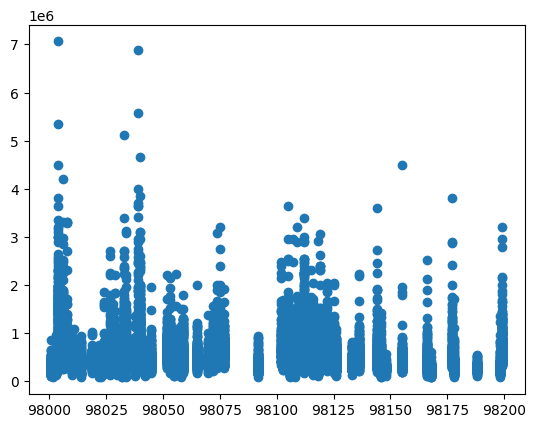

In [49]:
plt.scatter(data['zipcode'],data['prix'])
plt.show()

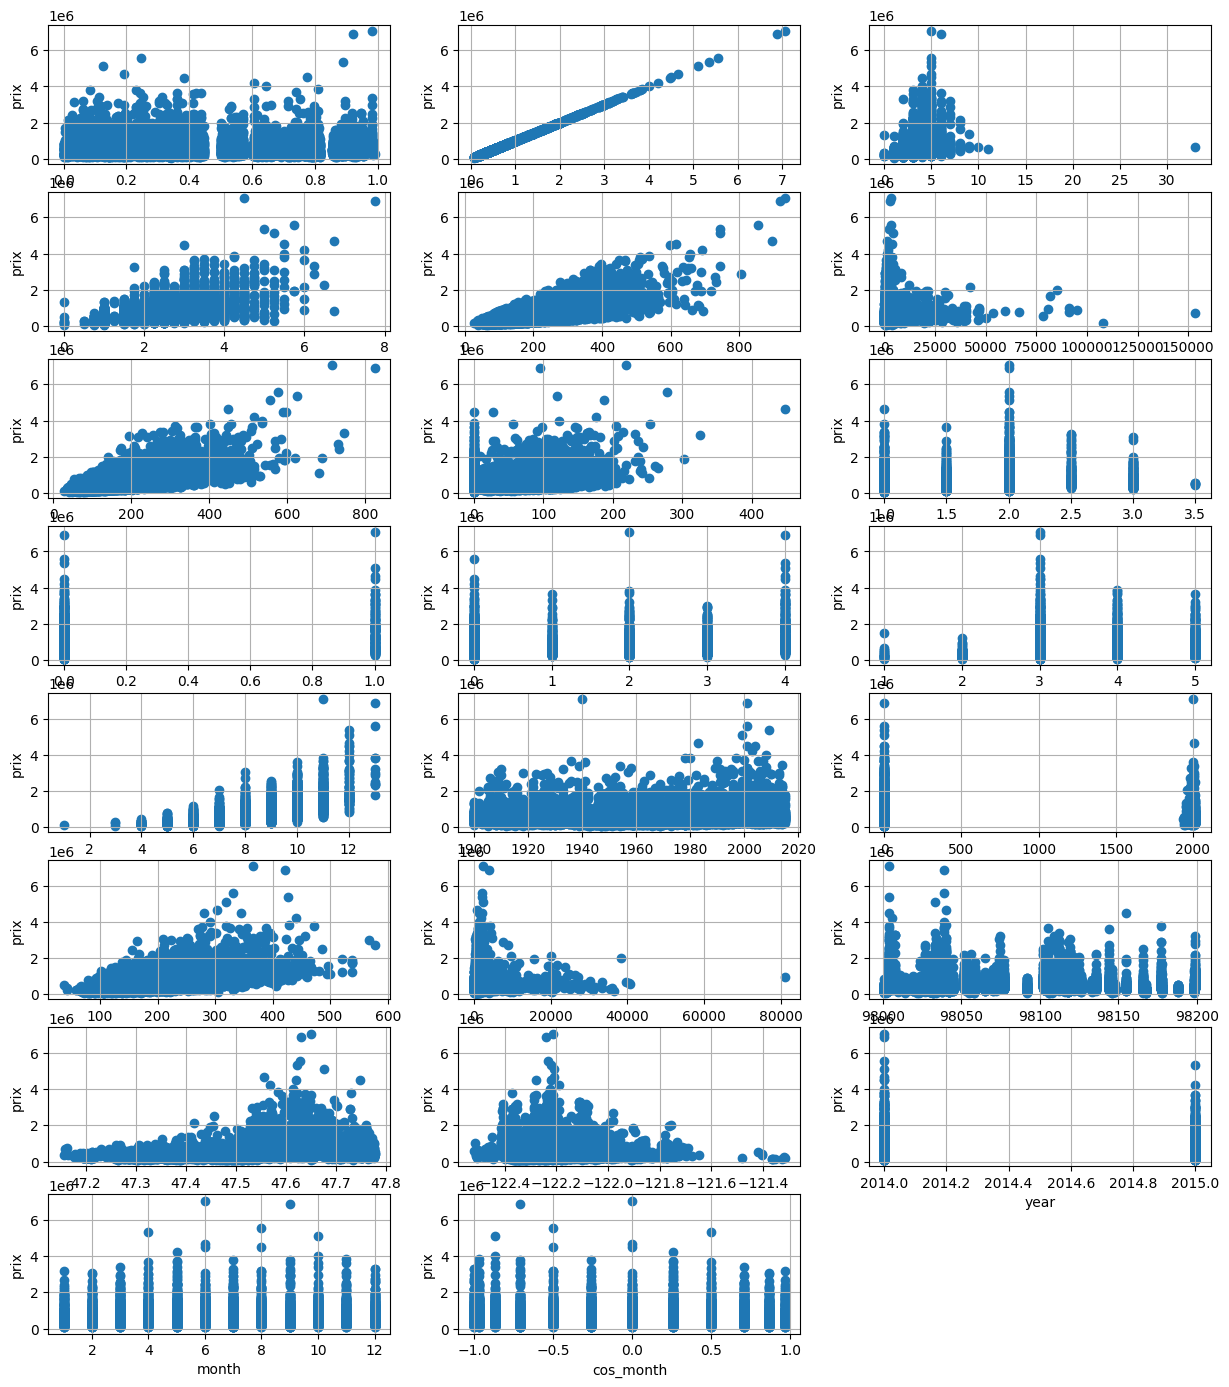

In [50]:
numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns


plt.figure(figsize=(15, 17))
for i, column in enumerate(numerical_columns):
    plt.subplot((len(numerical_columns) + 2) // 3, 3, i + 1)  # Calcule le nombre de lignes de sous-graphiques
    if data[column].dtype in ['int64', 'float64']:
      plt.scatter(data[column],data['prix'])
      plt.grid()
      plt.xlabel(column)
      plt.ylabel('prix')
plt.show()


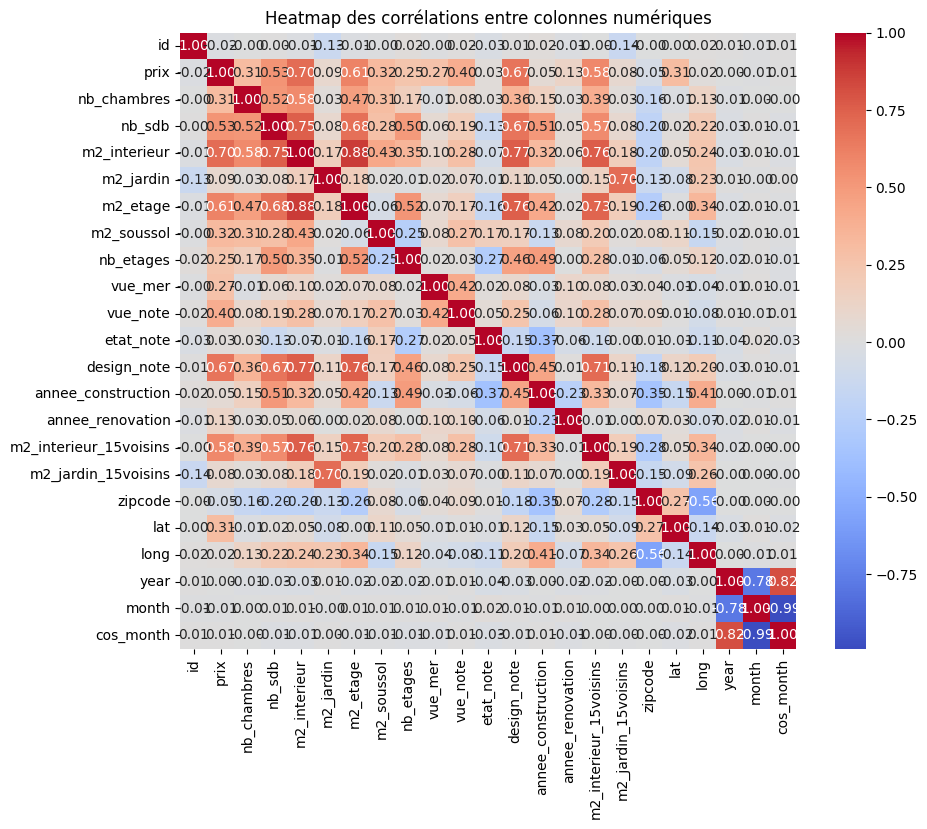

In [51]:
import seaborn as sns

# Calculer la matrice de corrélation
correlation_matrix = data[numerical_columns].corr()  # Calcul des corrélations

# Créer une heatmap
plt.figure(figsize=(10, 8))  # Taille de la figure
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title("Heatmap des corrélations entre colonnes numériques")
plt.show()

In [52]:
data = data.sort_values(by='date',axis = 0)


In [53]:
from sklearn.model_selection import train_test_split

var_y = 'prix'
y = data[var_y]

X = data.drop(['prix','id','date','zipcode'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, shuffle = False)

In [54]:

reg = LinearRegression().fit(X_train, y_train)
RMSE = np.sqrt(mean_squared_error(y_test, reg.predict(X_test)))
MAPE = mean_absolute_percentage_error(y_test, reg.predict(X_test)) * 100
print('RMSE :', round(RMSE),'MAPE :', round(MAPE, ndigits=2))

RMSE : 212379 MAPE : 25.25


#**en gardant les variables les plus significatives (critere p valeur)**

In [55]:
X_select = X
var_X_select = X_select.columns
linreg_comp_model = OLS(y, add_constant(X_select))
linreg_comp = linreg_comp_model.fit()
linreg_comp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   prix   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     2094.
Date:                Mon, 17 Mar 2025   Prob (F-statistic):               0.00
Time:                        09:40:34   Log-Likelihood:            -2.3396e+05
No. Observations:               17147   AIC:                         4.680e+05
Df Residuals:                   17127   BIC:                         4.681e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                  -1.073e+08   1.26e+07     -8.500      0.000   -1.32e+08   -8.26e+07
nb_chambres             -3.27e+04   2146.338    -15.234      0.000   -3.69e+04   -2.85e+04
nb_sdb                  4.284e+04   3692.243     11.602      0.000    3.56e+04    5.01e+04
m2_interieur            1176.8990     27.826     42.295      0.000    1122.358    1231.440
m2_jardin                  1.4811      0.568      2.609      0.009       0.368       2.594
m2_etage                 770.8474     27.408     28.125      0.000     717.125     824.570
m2_soussol               406.0521     32.309     12.568      0.000     342.724     469.380
nb_etages              -2114.5251   4061.779     -0.521      0.603   -1.01e+04    5846.977
vue_mer                 5.584e+05   1.93e+04     28.965      0.000    5.21e+05    5.96e+05
vue_note                5.069e+04   2433.045     20.833      0.000    4.59e+04    5.55e+04
etat_note                 3.3e+04   2676.056     12.330      0.000    2.78e+04    3.82e+04
design_note             1.004e+05   2441.703     41.122      0.000    9.56e+04    1.05e+05
annee_construction     -2443.1559     82.159    -29.737      0.000   -2604.196   -2282.115
annee_renovation          20.2089      4.130      4.893      0.000      12.113      28.305
m2_interieur_15voisins   260.7265     41.967      6.213      0.000     178.466     342.987
m2_jardin_15voisins       -4.5315      0.886     -5.117      0.000      -6.267      -2.796
lat                     5.732e+05   1.19e+04     48.032      0.000     5.5e+05    5.97e+05
long                   -1.208e+05   1.36e+04     -8.875      0.000   -1.47e+05   -9.41e+04
year                    3.443e+04   6205.384      5.549      0.000    2.23e+04    4.66e+04
month                   2460.2826   3984.206      0.618      0.537   -5349.169    1.03e+04
cos_month               6170.4369   2.08e+04      0.297      0.767   -3.46e+04    4.69e+04
==============================================================================
Omnibus:                    14068.617   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1155561.237
Skew:                           3.426   Prob(JB):                         0.00
Kurtosis:                      42.629   Cond. No.                     7.22e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.81e-23. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [56]:
var_eliminees = []
linreg_comp_model = OLS(y, add_constant(X))
linreg_comp = linreg_comp_model.fit()
while linreg_comp.pvalues.drop('const', errors='ignore').max() > 0.05:
    # on détermine la variable avec la p-value la plus élevée, sauf 'const'
    var_a_eliminer = linreg_comp.pvalues.drop('const', errors='ignore').idxmax()
    var_eliminees.append(var_a_eliminer)
    # Suppression de cette variable de var_X
    var_X_select = [var for var in var_X_select if var != var_a_eliminer]

    # mise à jour X avec les variables restantes
    X_select = X[var_X_select]

    # on redétermine la nouvelle régression linéaire
    linreg_comp_model = OLS(y, add_constant(X_select))
    linreg_comp = linreg_comp_model.fit()

linreg_select_model = OLS(y, add_constant(X_select))
linreg_select = linreg_select_model.fit()
linreg_select.summary()
var_eliminees



['cos_month', 'nb_etages', 'month']

In [57]:
X_train_select, X_test_select, y_train_select, y_test_select = train_test_split(X_select,y,test_size = 0.2, shuffle = False)

In [58]:
reg = LinearRegression().fit(X_train_select, y_train_select)
RMSE = np.sqrt(mean_squared_error(y_test_select, reg.predict(X_test_select)))
MAPE = mean_absolute_percentage_error(y_test_select, reg.predict(X_test_select)) * 100
print('RMSE :', round(RMSE),'MAPE :', round(MAPE, ndigits=2))

RMSE : 212356 MAPE : 25.24


#**FEATURE ENGINEERING**

In [59]:
data = pd.get_dummies(data, columns=['vue_mer', 'vue_note', 'etat_note', 'design_note', 'nb_sdb', 'nb_chambres', 'nb_etages'],dtype=int
)
X = data.drop(['date','prix','id','zipcode'],axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, shuffle = False)

In [60]:
print(X['nb_etages_1.0'].iloc[0])


0


In [61]:
X_select = X
var_X_select = X_select.columns
linreg_comp_model = OLS(y, add_constant(X_select))
linreg_comp = linreg_comp_model.fit()
linreg_comp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   prix   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     646.5
Date:                Mon, 17 Mar 2025   Prob (F-statistic):               0.00
Time:                        09:40:35   Log-Likelihood:            -2.3263e+05
No. Observations:               17147   AIC:                         4.654e+05
Df Residuals:                   17070   BIC:                         4.660e+05
Df Model:                          76                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                  -4.392e+07   5.19e+06     -8.469      0.000   -5.41e+07   -3.38e+07
m2_interieur             889.4971     27.027     32.912      0.000     836.522     942.472
m2_jardin                  1.4047      0.529      2.655      0.008       0.368       2.442
m2_etage                 429.0879     27.631     15.529      0.000     374.929     483.247
m2_soussol               460.4096     30.902     14.899      0.000     399.838     520.981
annee_construction     -1727.5689     86.281    -20.023      0.000   -1896.688   -1558.450
annee_renovation          35.5348      3.882      9.153      0.000      27.925      43.144
m2_interieur_15voisins   443.7064     40.185     11.041      0.000     364.939     522.474
m2_jardin_15voisins       -4.7626      0.825     -5.776      0.000      -6.379      -3.146
lat                     5.747e+05   1.12e+04     51.119      0.000    5.53e+05    5.97e+05
long                   -8.968e+04   1.28e+04     -6.986      0.000   -1.15e+05   -6.45e+04
year                    3.254e+04   5761.220      5.648      0.000    2.12e+04    4.38e+04
month                   4512.3524   3701.403      1.219      0.223   -2742.779    1.18e+04
cos_month               1.649e+04   1.93e+04      0.854      0.393   -2.13e+04    5.43e+04
vue_mer_0               -2.22e+07   2.59e+06     -8.564      0.000   -2.73e+07   -1.71e+07
vue_mer_1              -2.171e+07   2.59e+06     -8.373      0.000   -2.68e+07   -1.66e+07
vue_note_0             -8.891e+06   1.04e+06     -8.574      0.000   -1.09e+07   -6.86e+06
vue_note_1             -8.768e+06   1.04e+06     -8.452      0.000   -1.08e+07   -6.73e+06
vue_note_2             -8.831e+06   1.04e+06     -8.515      0.000   -1.09e+07    -6.8e+06
vue_note_3             -8.773e+06   1.04e+06     -8.458      0.000   -1.08e+07   -6.74e+06
vue_note_4             -8.654e+06   1.04e+06     -8.344      0.000   -1.07e+07   -6.62e+06
etat_note_1            -8.846e+06   1.04e+06     -8.525      0.000   -1.09e+07   -6.81e+06
etat_note_2            -8.805e+06   1.04e+06     -8.487      0.000   -1.08e+07   -6.77e+06
etat_note_3            -8.798e+06   1.04e+06     -8.482      0.000   -1.08e+07   -6.76e+06
etat_note_4            -8.757e+06   1.04e+06     -8.444      0.000   -1.08e+07   -6.72e+06
etat_note_5             -8.71e+06   1.04e+06     -8.399      0.000   -1.07e+07   -6.68e+06
design_note_1          -3.784e+06   4.75e+05     -7.963      0.000   -4.72e+06   -2.85e+06
design_note_3          -3.815e+06   4.48e+05     -8.523      0.000   -4.69e+06   -2.94e+06
design_note_4          -4.017e+06   4.34e+05     -9.256      0.000   -4.87e+06   -3.17e+06
design_note_5          -4.055e+06   4.33e+05     -9.373      0.000    -4.9e+06   -3.21e+06
design_note_6          -4.031e+06   4.33e+05     -9.318      0.000   -4.88e+06  

In [62]:
var_eliminees = []
linreg_comp_model = OLS(y, add_constant(X))
linreg_comp = linreg_comp_model.fit()
while linreg_comp.pvalues.drop('const', errors='ignore').max() > 0.05:
    # on détermine la variable avec la p-value la plus élevée, sauf 'const'
    var_a_eliminer = linreg_comp.pvalues.drop('const', errors='ignore').idxmax()
    var_eliminees.append(var_a_eliminer)
    # Suppression de cette variable de var_X
    var_X_select = [var for var in var_X_select if var != var_a_eliminer]

    # mise à jour X avec les variables restantes
    X_select = X[var_X_select]

    # on redétermine la nouvelle régression linéaire
    linreg_comp_model = OLS(y, add_constant(X_select))
    linreg_comp = linreg_comp_model.fit()

linreg_select_model = OLS(y, add_constant(X_select))
linreg_select = linreg_select_model.fit()
linreg_select.summary()
var_eliminees

['cos_month', 'month']

In [63]:
X_train_select, X_test_select, y_train_select, y_test_select = train_test_split(X_select,y,test_size = 0.2, shuffle = False)

In [64]:
reg = LinearRegression().fit(X_train_select, y_train_select)
RMSE = np.sqrt(mean_squared_error(y_test_select, reg.predict(X_test_select)))
MAPE = mean_absolute_percentage_error(y_test_select, reg.predict(X_test_select)) * 100
print('RMSE :', round(RMSE),'MAPE :', round(MAPE, ndigits=2))

RMSE : 198016 MAPE : 22.54


In [65]:
X = add_constant(X)

VIF = pd.DataFrame()
VIF['Variables'] = X.columns
VIF['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(VIF[1:len(X.columns)])

c:\Users\rapha\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\rapha\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


             Variables       VIF
1         m2_interieur       inf
2            m2_jardin  2.018730
3             m2_etage       inf
4           m2_soussol       inf
5   annee_construction  3.080267
..                 ...       ...
80       nb_etages_1.5       inf
81       nb_etages_2.0       inf
82       nb_etages_2.5       inf
83       nb_etages_3.0       inf
84       nb_etages_3.5       inf

[84 rows x 2 columns]


In [73]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_select, y_train_select)
y_pred_select = model.predict(X_test_select)
RMSE = np.sqrt(mean_squared_error(y_test_select, y_pred_select))
MAPE = mean_absolute_percentage_error(y_test_select, y_pred_select) * 100
print('RMSE :', round(RMSE),'MAPE :', round(MAPE, ndigits=2))

RMSE : 139631 MAPE : 13.42


#**UTILISATION DU MODELE SUR LE CSV DE TEST**#

In [67]:
data_pred = pd.get_dummies(data_pred, columns=['vue_mer', 'vue_note', 'etat_note', 'design_note', 'nb_sdb', 'nb_chambres', 'nb_etages'],dtype=int
)
X_pred = data_pred.drop(['date','prix','id','zipcode'],axis = 1).drop(var_eliminees,axis = 1)

In [68]:
set(X_train.columns) - set(X_pred.columns)


{'cos_month',
 'design_note_1',
 'design_note_13',
 'design_note_3',
 'month',
 'nb_chambres_11',
 'nb_chambres_33',
 'nb_sdb_1.25',
 'nb_sdb_6.25',
 'nb_sdb_6.75',
 'nb_sdb_7.75'}

In [69]:
# Ajouter les colonnes manquantes avec des zéros
for col in X_train_select.columns:
    if col not in X_pred.columns:
        X_pred[col] = 0

# Supprimer les colonnes en trop (si nécessaire)
X_pred = X_pred[X_train_select.columns]


In [70]:
y_pred = np.exp(model.predict(X_pred))

C:\Users\rapha\AppData\Local\Temp\ipykernel_12384\152385994.py:1: RuntimeWarning: overflow encountered in exp
  y_pred = np.exp(model.predict(X_pred))


In [71]:
path_pred_raph = "C:/Users/rapha/OneDrive/Bureau/ENPC/2A/SEMESTRE 2/PRAMA/PRAMA2025/predictions/prediction_raph.csv"
pred_raph = pd.read_csv(path_pred_raph)
pred_raph['prix']=y_pred
pred_raph.to_csv(path_pred_raph, index=False)